# Transformer, Self-Attention и моделирование языка

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, \
    save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
    GreedyGenerator, BeamGenerator
from dlnlputils.pipeline import train_eval_loop, init_random_seed
from dlnlputils.base import get_params_number

init_random_seed()

## Загрузка текстов и разбиение на обучающую и тестовую подвыборки

Рассмотрим темы моделирования языка, механизмов внимания и рассмотрим архитектуру "трансформер". Проверять работоспособность методов будем с помощью известного произведения Льва Николаевича Толстого "Война и мир". В нашем случае, обучающая выборка — это просто большой текстовый файл без всякой разметки. При загрузке текста мы читаем весь его в память, а потом нарезаем на кусочки размером в 200 символов. Таким образом мы получим набор небольших фрагментов текста, но, при этом, длина каждого фрагмента будет больше, чем длина отдельного предложения. Современные языковые модели работают с более длинными последовательностями, поэтому общепринятая схема — это "не выполнять разбиение текста на отдельные предложения перед подачей их в языковую модель". Всего у нас получилось около 8 тысяч фрагментов. На экране один такой фрагмент. Он содержит фрагменты двух предложений. 

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
all_chunks = load_war_and_piece_chunks('./datasets/war_and_peace.txt')
print(len(all_chunks))
print(all_chunks[10])

7976
у нее был грипп, как она говорила (грипп был тогда новое
слово, употреблявшееся только редкими). В записочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez


Как обычно, разобьём все наши данные на обучающую и тестовую выборку в соотношении 70% в обучающую выборку, 30% в тестовую. 

In [3]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 5583
Размер валидационной выборки 2393


## Токенизация корпуса с помощью BPE


Современные языковые модели работают, как правило, не с целыми токенами. Они работают с фрагментами слов, или, так называемыми "sub-word units" (по сути, это N-граммы символов). Поэтому для токенизации мы используем не классический токенизатор с помощью регулярных выражений или каких-то других правил (например, как те которые мы использовали в предыдущих семинарах). Здесь мы используем алгоритм "byte pair encoding" (BPE). Напомню, в двух словах, как он работает, в чём его основной принцип. Допустим, у нас есть последовательность символов: "ABCABE", например. Тогда, сначала, этот алгоритм будет искать наиболее частотную биграмму (в данном случае это "AB"), и он заменит её в тексте на какой-то новый символ, который в тексте ранее не встречался. Например, мы получим "XCXE". Такая же операция поиска наиболее частотной биграммы и замены её на новый символ будет повторяться в цикле. Например, на следующем шаге мы заменим биграмму "XC" на какой-нибудь символ "Y" и получим новую последовательность, и так далее. Таким образом мы последовательно сжимаем текст и, в процессе сжатия текста, запоминаем те замены, которые мы сделали. Например, мы можем запомнить, что "AB" было заменено на "X", а "XC" заменено было на "Y". Такой алгоритм позволяет получить нечто среднее между алгоритмами, работающими на уровне отдельных токенов, и на уровне отдельных символов. Когда мы работаем с отдельными символами, у нас алфавит маленький, то есть решать задачу классификации нам попроще, но длина последовательностей растёт и поэтому нам нужно строить модели, которые умеют запоминать далёкие зависимости. Это достаточно сложно. Наоборот, если мы работаем с отдельными токенами, то последовательности у нас гораздо короче. Но, с другой стороны, словарь у нас разрастается очень быстро (нам нужно уметь предсказывать каждый отдельный токен, а токенов очень много — гораздо больше, чем символов). И поэтому, с одной стороны, нам нужно помнить более короткие зависимости, но, зато, задача классификации становится сложной, потому что классов очень много. Алгоритмы, такие как byte pair encoding, позволяют найти золотую середину между этими двумя крайностями. В этом семинаре мы будем использовать реализацию byte pair encoding из библиотеки "YouTokenToMe". Эта библиотека была разработана "ВКонтакте"[1] и, на сегодняшний день, является самой быстрой реализацией byte pair encoding. 

In [4]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
BPE_MODEL_FILENAME = './models/4.6.war_and_peace_bpe.yttm'

Основной модуль библиотеки реализован не на python, и поэтому наиболее удобный и быстрый способ скармливания данных в эту библиотеку — это через текстовый файл. Поэтому мы, сначала, сохраняем все наши тексты в этот файлик, а затем вызываем функцию обучения. И функция обучения читает данные из текстового файла и складывает обученную модель (то есть, словарь замен) в другой файлик, который мы указали. Самый важный параметр здесь — это размер словаря. Он и позволяет нам выбрать, что мы хотим — более длинные последовательности, но меньший словарь, или более короткие последовательности, но более крупный словарь, и, чем больше наш словарь, тем больше будет редких классов — это будет создавать нам некоторые сложности при обучении.

In [5]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
TRAIN_TEXTS_FILENAME = './datasets/war_and_peace_bpe_train.txt'
save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);

Training parameters
  input: ./datasets/war_and_peace_bpe_train.txt
  model: ./models/war_and_peace_bpe.yttm
  vocab_size: 1000
  n_threads: 8
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 142
number of deleted characters: 0
number of unique characters left: 142
model saved to: ./models/war_and_peace_bpe.yttm


 Когда модель обучена, мы создаём экземпляр класса "bpe" и передаём туда путь к файлу с обученной моделью. Давайте посмотрим на словарь, который наша модель выучила. 

In [6]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з б . ч й - ж ш e х ю s ц a n r i u o t щ э П l Н ф А В m d c О ? ! К Д Б p М v Р " ) С ( ' ; И Т ё 1 h : Я 2 q f Г ъ b g Ч Э 0 3 Е 5 ] [ j 4 I z Л З 6 8 M A 9 7 У Ж V L x X Ф Ш y C Х J B P D E N S k Ц R Q O T ` w Ю H U F G K Ь W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ру ет ▁ко ▁бы ми ны ня да ▁то ди хо ▁за ▁го ем ▁г ▁он ол ени ▁от ки ви ну каз е, ▁э та ▁П ти ши ▁при ▁вы ▁ра му ▁Н ▁ж ов ▁вс ле ▁А до ▁В ▁про ▁мо ля ▁как мо ▁во казал ры ▁его ма ▁об сто ▁это ль й, ▁сказал ере не ▁а ▁до ▁О ▁я ▁К ▁кото ▁сво ▁кня ▁Д м, у, ше ▁Б али по чи ▁но сти ▁ни си ча ста ель ▁из ве лу ала де ▁Ан вори ▁М ▁под ▁ка ▁d .. ша ... за ска жи ще es я, лся ▁со че лы зь сть ско ou ▁ли ▁хо ▁ви ▁ст ень ▁ру ря енно ▁Пь ▁так ме ты ▁p ▁Р ги га дел лю сно re же ▁раз ▁( со те ду ку ▁се ски ▁c ▁С ▁ва вши ▁все тель бе en вал ▁l ▁дру ▁было ▁И on

Мы сказали алгоритму выделить тысячу наиболее характерных N-грамм через byte pair encoding. Вот какие N-граммы нашлись. Во-первых, словарь содержит несколько служебных токенов — это токен "padding", то есть токен, предназначенный для выравнивания длин последовательностей, чтобы их подавать в нейросеть; это токен "unknown" — это когда алгоритм встретил в тексте какую-то N-грамму, которую не видел при обучении; и два токена "beginning of sequence" и "end of sequence". Мы сказали алгоритму: "Пожалуйста, выдели нам тысячу наиболее характерных N-грамм через byte pair encoding". Вот какие N-граммы нашлись. Во-первых, словарь содержит несколько служебных токенов — это токен "padding", то есть токен, предназначенный для выравнивания длин последовательностей, чтобы их подавать в нейросеть; это токен "unknown" — это когда алгоритм встретил в тексте какую-то N-грамму, которую не видел при обучении; и два токена "beginning of sequence" и "end of sequence". Далее идёт набор юниграмм, то есть, по сути — это все уникальные символы, которые встретились в обучающей выборке. А вот дальше уже идут более сложные конструкции, причём здесь идут вперемешку как биграммы и так и более длинные последовательности. Мы можем видеть здесь как фрагменты слов (какие-то устойчивые подслова, то есть основы слова) можем видеть имена людей без окончания (как, например, "Андрей", "Ростов", и так далее). Также здесь есть и явно слишком специфические последовательности (например, " Пьер,"). Скорее всего, это сигнал к тому, что можно сделать словарь поменьше для нашей модели. Но это не так очевидно, нужно смотреть на метрики на отложенной выборке, чтобы выбрать правильный размер словаря. 

Токенизатор из библиотеки "YouTokenToMe" принимает на вход не отдельный текст, а сразу список текстов (список строк) и на выходе возвращает список списков, каждый вложенный список содержит числа — это номера токенов (номера N-грамм) в словаре. В принципе, как обычно. 

In [7]:
print(tokenizer.encode(train_texts[:1]))

[[210, 238, 244, 13, 317, 16, 147, 200, 12, 265, 35, 161, 337, 490, 203, 269, 447, 4, 111, 111, 96, 27, 415, 148, 176, 551, 201, 726, 199, 161, 848, 889, 772, 23, 16, 690, 179, 585, 18, 154, 412, 19, 382, 157, 186, 635, 10, 518, 774, 363, 670, 157, 793, 37, 7, 426, 791, 186, 635, 10, 518, 774, 650, 25, 988, 206, 186, 13, 201, 8, 149, 474, 17, 275, 31, 23, 8, 34, 444]]


In [8]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

Посмотрим — а какой длины последовательности после токенизации у нас получились. Когда мы загружали датасет, мы нарезали исходный текст на кусочки длиной 200 символов. В результате токенизации, большая часть фрагментов получила длину от 60 до 140, примерно. Причём наиболее распространённая длина последовательности — мода — около 80, то есть получилось сжать среднюю длину текста чуть более, чем в два раза. Таким образом, с точки зрения длины последовательности, задача уже проще, чем моделирование языка на уровне отдельных символов. 

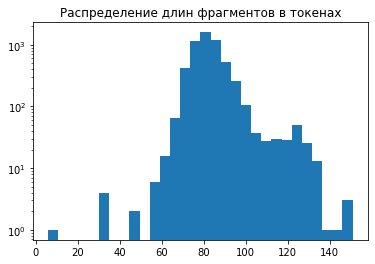

In [9]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

Если мы построим гистограмму частот встречаемости токенов, то найдём распределение Ципфа: у нас очень мало частотных N-грамм (то есть тех N-грамм, которые встретились больше 2000 раз — их, наверное, меньше 20 суммарно), и основное количество N-грамм встретилось порядка нескольких сотен раз. Надо сказать, что очень редких N-грамм (то есть, вот этот — самый левый столбик) — их небольшое количество (около 100, всего лишь), то есть большая часть словаря у нас не является редкими классами. Это хорошая новость — всегда проще решать задачу классификации, когда классы сбалансированы. Когда мы обучали наш токенизатор, мы использовали только обучающую подвыборку всех данных, то есть только 70% текстов. Логично, что в остальных 30% могут встретиться токены, которые не встречались в обучающей выборке. Но мы используем здесь BPE, и поэтому в тестовой выборке, на самом деле, не оказалось токенов, которые бы мы не увидели в том или ином виде в обучающей выборке. То есть — да, может быть, какие-то длинные N-граммы мы там не нашли, но зато мы смогли эти длинные N-граммы разбить на более мелкие, и, всё равно, все символы у нас так или иначе нашлись в словаре. Таким образом, когда у нас в новом тексте встречаются только неизвестные слова, то BPE просто деградирует до character-level, то есть наша модель просто становится моделью на уровне отдельных символов.

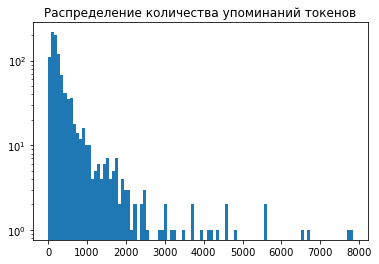

In [10]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [11]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


## Подготовка датасетов для PyTorch

Как обычно, давайте создадим специальную структуру данных — Dataset, который будет готовить обучающие примеры для того, чтобы подавать их в pytorch для обучения. Для этой цели мы написали специальный класс "LanguageModelDataset", который принимает на вход список токенизированных предложений, в которых токены заменены на их номера. А также он принимает длину фрагмента которую нужно подавать в модель за раз. То есть, это наибольшее количество токенов, которые модель будет видеть за раз. Давайте посмотрим, как этот Dataset работает. Как обычно, наш Dataset реализует два основных метода — это получение длины датасета (то есть, количества примеров) и "get_item" — это получение одного конкретного примера по его порядковому номеру. Когда мы готовим очередной пример для модели, мы выбираем по индексу фрагмент текста, затем из всего текста мы выбираем какой-то случайный подфрагмент, непрерывный. И делаем из этого фрагмента ещё два кусочка — первый кусочек (здесь это переменная "seed part") — это весь текст, кроме последнего символа. А "target_part" — это весь текст, кроме первого символа. Таким образом, мы получаем, как бы, два текста — "seed_part" у нас выполняет роль входа в модель, а "target_part" — это то, что мы ожидаем на выходе модели. Таким образом, если у нас есть, например, текст "ABCD", тогда "seed-part" — это "ABC", а "target_part" — это "BCD". Физический смысл у этих последовательностей — следующий. На очередной позиции в "target" стоит токен, который модель должна предсказать, прочитав столько же токенов из входной последовательности. Таким образом, токен "B" она должна уметь предсказать только лишь по токену "A", токен "C" модель должна уметь предсказывать из "AB", а токен "D" она должна уметь предсказывать из всей входной последовательности, то есть "ABC". 

In [12]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

На экране один пример, сгенерированный нашим Dataset. Мы видим что здесь токены, как бы, смещены на одну позицию влево всегда, и на очередной позиции вектора "target" у нас стоит токен, который нужно уметь предсказывать после прочтения всех предыдущих токенов. 

In [13]:
train_dataset[0]

(array([  2, 210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161,
        337, 490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176,
        551, 201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,
         18, 154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670,
        157, 793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25,
        988, 206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,
         34, 444]),
 array([210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161, 337,
        490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176, 551,
        201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,  18,
        154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670, 157,
        793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25, 988,
        206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,  34,
        444,   3]))

Токенайзер из библиотеки "YouTokenToMe" умеет и декодировать тексты. То есть, обратно преобразовывать их в текст (то есть в строку). На экране вы видите пример детокенизации, то есть мы взяли тот же самый обучающий пример и прогнали его через детокенизатор. Мы видим, что две последовательности, входная и выходная, сдвинуты относительно друг друга на один токен, на одну N-грамму. 

In [14]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш',
 'от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш<EOS>']

## Общие классы и функции

### Маска зависимостей

Если мы будем просто в лоб подавать текст и на выходе просить его же — действительно, модель ничего не выучит. Нам нужно усложнить ей задачу, нам нужно сделать так, чтобы при предсказании i-го токена она принципиально не могла учитывать токены, стоящие справа от этой позиции. Для этого мы будем использовать специальную маску. На экране вы видите функцию, которая генерирует такую маску и, собственно, пример этой маски — давайте разберём, какой физический смысл у этой маски. 

In [15]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Это так называемая "маска зависимости позиций". Для примера мы сгенерировали эту маску для достаточно короткой последовательности длины 10. Маска имеет размер 10 на 10, это квадратная матрица, строка соответствует номеру позиции в выходной последовательности, а столбцы соответствуют номерам позиций во входной последовательности, и на пересечении столбца и строки стоит 0, если при предсказании токена на позиции "i" можно учитывать токен на позиции "j". То есть, если учитывать можно — тогда стоит 0, а если учитывать нельзя — тогда стоит -∞. Таким образом, мы "запрещаем" модели смотреть на все токены справа. И, например, для самого первого токена (это первая строчка) мы можем использовать только самый первый входной токен. Для второго токена в выходной последовательности мы можем использовать уже два токена, а для последнего выходного токена мы можем использовать всю входную последовательность. Если в двух словах — то эти маски подаются в механизм внимания для того, чтобы занулить веса определённых элементов, чтобы мы не учитывали определённые входные позиции при расчёте выходных позиции. Она используется именно в механизмах внимания. Как именно она там используется, мы рассмотрим чуть позже.

### Кодирование позиции

Следующий вспомогательный элемент, который нам нужен — это позиционное кодирование. Механизм self-attention — он, в некотором смысле, похож на механизм свёрток, тем, что он инвариантен к позиции элемента в последовательности. Мы можем за одну операцию сравнить каждый элемент последователи с любым другим элементом последовательности. Но кажется, что, когда мы работаем с текстами, особенно с текстами с фиксированным порядком слов, нам важно учитывать позиции токенов. Даже если порядок слов и не фиксированный, то относительные позиции токенов уж точно полезны. Потому что всё-таки это достаточно редкий случай — когда связь между словами идёт через пол-текста. Даже для человека такие связи были бы очень сложными. Нам нужно учитывать относительные позиции токенов. Для того, чтобы закодировать позиции токенов, к эмбеддингу токена, который мы берём из таблички, будем прибавлять эмбеддинг позиции, то есть вектор такой же длины, что и эмбеддинг токена, который имеет разное значение для разных позиций. И самый, наверное, интуитивный способ закодировать позицию — это использовать какой-то периодический сигнал. Авторы трансформера предлагают использовать набор синусоид и косинусоид разной частоты. На экране вы видите график, который изображает сразу несколько таких векторов. Один срез графика (вертикальный) описывает нам эмбеддинг одной позиции. Вы можете видеть, что здесь есть как высокочастотные сигналы (как, например, вот этот), так и низкочастотные (как вот эта горизонтальная прямая, или вот этот голубой график). Таким образом, по изменению сигнала на определённых позициях мы можем определить, как далеко друг от друга два токена находятся. 

In [16]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

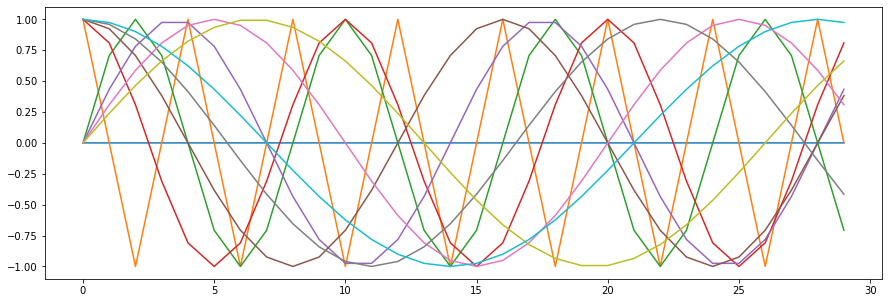

In [17]:
sample_pos_codes = make_positional_encoding(30, 30)
plt.plot(sample_pos_codes[:, ::3].numpy());
plt.gcf().set_size_inches((15, 5))

### Основной класс - языковая модель

Начнём строить какие-нибудь модельки. Для удобства, определим общий класс — "языковая модель". Этот класс будет выполнять некоторые базовые операции вне зависимости от архитектуры нейросети, которая языковую модель будет реализовывать. К таким операциям относится хранение векторов слов, получение кодов позиций, а также предсказание токенов для каждой позиции. Посмотрим на метод "forward" и разберём основные шаги. На вход к нам приходит прямоугольная матрица, в ней количество строк соответствует количеству примеров в батче, а количество столбцов — наибольшей длине последовательности. Зная длину последовательности мы можем сгенерировать маску зависимостей, то есть вот эту вот треугольную матрицу из нулей и минус бесконечности. А также мы можем сгенерировать ещё одну маску, которая нам помечает токены за границей последовательности. То есть, если последовательность короче, чем "max in_len" (то есть — чем наибольшая длина входной последовательности), то она будет "добиваться" нулями до конца, до наибольшей длины, и нам нужно исключить эти нули из рассмотрения, из предсказаний. Для этого мы используем "padding mask". Теперь нам нужно получить начальное представление токенов для того, чтобы их подать уже в нейросеть. Вектора токенов у нас будут складываться из двух компонент, а именно: эмбеддинг самого токена и эмбеддинг позиции. Эмбеддинги токенов мы берём просто из таблички, для этого мы используем стандартный модуль из pytorch — nn.embedding. Как обычно, мы помечаем, что нулевой токен — это фиктивный токен, то есть "padding". Этот модуль, по сути, осуществляет всего лишь выборку строк из матрицы по индексам. И он позволяет обучать эмбеддинги, что называется, "end to end". То есть эмбеддинги будут получать обновления на каждом градиентном шаге. На выходе из эмбеддинг слоя мы уже имеем не двухмерную матрицу, прямоугольную, а трёхмерный тензор. У нас добавилось ещё одно измерение, соответствующее количеству элементов в эмбеддинге. Для того, чтобы получить эмбеддинги позиций, мы используем функцию, которую рассмотрели чуть ранее. Она возвращает нам прямоугольную матрицу размерности ["длина последовательности" на "размер эмбеддинга"]. То есть, в ней нет измерения, соответствующего количеству примеров в батче. Чтобы иметь возможность сложить два тензора эмбеддингов — то есть, эмбеддинги токенов и эмбеддинги позиции, мы добавляем некоторое фиктивное измерение (добавляем единичку). После этой операции тензоры "seed_embs" и "pos_codes" будут оба трёхмерными, их можно будет сложить — что мы, собственно, и делаем. Далее к полученным эмбеддингам мы применяем dropout. На самом деле, dropout здесь очень драматично влияет на возможности модели переобучаться. Я предлагаю вам ответить на вопрос — какой dropout важнее: этот, или те dropout, которые находятся в основной нейросети (которая собственно, предсказывает токены). Далее мы подаём признаки токенов в некоторую нейросеть, которая здесь у нас лежит в переменной "backbone". Какая это нейросеть — здесь пока здесь не определено, это определяется при создании экземпляра класса "LanguageModel". Кроме эмбеддингов мы передаём туда две маски — маску зависимости и маску padding. Нейросеть "backbone" возвращает нам, также, трёхмерный тензор такой же размерности, что и была на входе, то есть ["количество элементов в батче", "максимальная длина последовательности" и "размер вектора представления"], (то есть рабочая размерность). Размерность модели, то есть величина последнего измерения тензора, не соответствует размеру словаря — это вполне нормально, мы не хотим растить ширину модели линейно с ростом количества токенов в словаре (это слишком дорого). Поэтому нам нужен дополнительный слой, который преобразует какой-то вектор в распределение вероятностей токенов в словаре. Для этого мы используем простой линейный слой. Когда вы подаёте на вход линейному слою какой-то многомерный тензор, то линейная проекция применяется к последнему измерению. Выходной тензор у нас представляет логиты (то есть он представляет не сами вероятности, распределения вероятностей, а логиты). Чтобы получить распределение вероятностей из логитов, нам нужно применить к этому тензору softmax по последнему измерению. Но мы не будем это делать, потому что мы знаем, что после логитов сразу пойдёт кросс-энтропия, а если у нас софтмакс и кросс энтропия, то можно софтмакс не брать полностью, можно лишние экспоненты и логарифмы сократить, и получить большую вычислительную стабильность. Не будем считать софтмакс на выходе модели. 

In [18]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length) \
            .to(seed_token_ids.device)
        
        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length,
                                             self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = seed_embs
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

### Утилиты для обучения - функция потерь и расписание изменения длины градиентного шага

Определим парочку стандартных вспомогательных компонент. Во-первых, нам нужна функция потерь. В качестве функции потерь мы будем использовать кросс-энтропию, но, перед тем, как подавать данные в функцию расчёта кросс-энтропии, мы просто их вытянем в линию. То есть мы, как бы, забудем, что у нас были отдельно — примеры в батче, и отдельно — токены в предложениях. Мы смешаем все предложения в кучу. Для оценки кросс-энтропии это совершенно не важно. А ещё мы скажем что нужно игнорировать padding. Это сделает фактическое распределение классов сильно менее скошенным и улучшит сходимости. Хотя вы можете выключить это и посмотреть, как это повлияет. А также, другая стандартная утилитка — это расписание изменения длины градиентного шага. Мы говорим, тем самым, что, если в течение двадцати эпох значение функции потерь на валидации не уменьшилось существенно, тогда — уменьшить длину градиентного шага в два раза. Использование такого "расписания" позволяет исключить ошибки, когда вы устанавливаете слишком большой "learning rate" при обучении, то есть если вы поставите слишком большой "learning rate", то модель просто не будет учиться и, в результате, "learning rate" автоматически уменьшится. Да, он уменьшится не сразу (а спустя вот такое вот количество эпох), но, тем не менее, если вы запустили эксперимент на ночь и ушли, то, скорее всего, утром вы получите обученную модель. 

In [19]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

## Реализация Transformer из PyTorch 1.2

Предпримем первую попытку обучить языковую модель, используя реализацию трансформера из библиотеки pytorch. Мы будем использовать не весь трансформер, а только его первую часть — трансформер "encoder". Этот вспомогательный класс нам нужен для двух задач. По какой-то причине, стандартная реализация трансформера умеет работать с тензорами, в которых первое измерение соответствует не размеру батча, а длине последовательности, а "batch_size" стоит на втором месте. Таким образом, этот класс делает, по сути, всего лишь две вещи. Во-первых, он транспонирует тензор перед подачей в трансформер, транспонирует результаты работы трансформера обратно, и возвращает результат не изменённым. И — вторая важная деталь — это инициализация параметров. По умолчанию, в трансформере используется равномерный шум с амплитудой, подбираемой исходя из количества входных признаков. Эта схема инициализации реализовывается в pytorch функцией "xavier_uniform". Таким способом, мы инициализируем все веса, кроме bias, то есть все "матричные" веса. .

In [20]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

Наша модель реализуется базовым классом "LanguageModel". Мы передаём размер словаря (это 1000, в данном случае), размер эмбеддинга (256 элементов) и он же — это размер модели. А также передаём туда экземпляр backbone нейросети, то есть — это та нейросеть, которая будет производить агрегацию контекстов, будет сравнивать слова с соседними словами и, таким образом, на вход она будет получать эмбеддинги отдельных токенов, а на выходе у неё уже будут эмбеддинги фраз, предложений. То есть — более крупных конструкций. Мы будем использовать три слоя self-attention и будем использовать не очень большой dropout. Как мы видим, модель содержит примерно 2 миллиона параметров. Это не очень большая модель (по современным меркам). Попробуем обучить модель. Для этого мы будем использовать нашу стандартную функцию, которую мы использовали весь курс до этого. На что здесь нужно обратить внимание — это то, что мы передаём сюда функцию потерь, "lm cross entropy", то есть — это та функция, которую мы определили, это не просто функция кросс-энтропии из pytorch. А также здесь стоит большой batch_size. А ещё я поставил большое количество эпох здесь. То есть, я ожидаю, что модель будет сходиться не очень быстро. В самом деле, на каждой эпохе мы делаем всего лишь 11 итераций, потому что у нас небольшой датасет (как мы помним, в нём примерно 6000 обучающих фрагментов и 3000 тестовых), и при таком большом размере батча мы делаем маленькое количество обновлений, поэтому нам нужно побольше эпох. Зато каждая эпоха проходит очень быстро. В моём случае, потребовалось примерно 800 эпох, то есть чуть больше чем 8000 градиентных шагов, чтобы модель более-менее сошлась. Сходимость модели мы проверяем по среднему значению функции потерь на отложенной выборке. То есть, спустя примерно 800 тысяч шагов, функция потерь на валидации перестала улучшаться, поэтому мы досрочно остановили обучение. 

In [21]:
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256,
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


In [22]:
# (best_val_loss,
#  best_torch_transf_model) = train_eval_loop(torch_transf_model,
#                                             train_dataset,
#                                             test_dataset,
#                                             lm_cross_entropy,
#                                             lr=2e-3,
#                                             epoch_n=2000,
#                                             batch_size=512,
#                                             # device='cuda',
#                                             early_stopping_patience=50,
#                                             max_batches_per_epoch_train=1000,
#                                             max_batches_per_epoch_val=1000,
#                                             lr_scheduler_ctor=lr_scheduler)

# Хорошая практика — сохранять модели на промежуточных итерациях для того чтобы если, например, 
# вам придётся досрочно остановить обучение или вы захотите усреднить модели (веса моделей с 
# разных итераций) между собой (это, кстати, хорошая практика, она позволяет немного улучшить качество). 
# В данном случае мы сохраняем только последнюю лучшую модель и тут же её загружаем, чтобы поиграться немножко. 

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
# torch.save(best_torch_transf_model.state_dict(), './models/4.6.war_and_peace_torch_transf_best.pth')

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch_transf_model.load_state_dict(torch.load('./models/4.6.war_and_peace_torch_transf_best.pth'))

<All keys matched successfully>

## Генерация текста с помощью языковой модели

### Жадная генерация

Как вы помните из лекции, существует два основных подхода к декодированию текста из языковой модели. Это полностью жадный алгоритм декодирования — то есть, когда мы на каждом шаге берём наиболее вероятный токен. И, при этом, наиболее вероятный токен мы выбираем без учёта совместного распределения токенов (то есть — вот на этом шаге модель сказала, что токен "А" самый лучший — мы его и берём вне зависимости от того, какой следующий токен может быть, или предыдущий). Этот алгоритм мы реализовали в нашей библиотеке в классе "GreedyGenerator". Он получает на вход обученную модель и "tokenizer". А затем он будет получать на вход текст и выдавать новый текст. Собственно, алгоритм предельно простой — сначала мы токенизируем наше предложение. Затем мы делаем некоторое количество шагов, но не более заданного числа шагов. И, на каждом шаге, мы полностью перевычисляем модель, то есть мы берём все входные токены, которые накопили к данному шагу, заворачиваем их в тензор, копируем на видеокарту и прогоняем через модель, а потом выбираем наиболее вероятный последний токен. Здесь "batch_size" равен 1, то есть мы берём в этом "indexer" первый элемент батча (он соответствует нашему предложению) и последний элемент в последовательности. Таким образом, после взятия этих индексов у нас на выходе будет вектор размерности, соответствующей размеру словаря. И мы просто берём токен с наибольшим весом из этого вектора. Как вы помните, наша модель возвращает не распределение вероятностей, а логиты, то есть это какие-то ненормированное числа. Чтобы получить распределение вероятностей, в этом случае, нам нужно ещё софтмакс применить к этим векторам. Но если мы хотим делать только "arg max", то нам не нужен "softmax", потому что он сглаживает величины, приводит их в диапазон от нуля до единицы, но он их не переупорядочивает, а значит точка максимума не изменится. Вот мы выбираем лучший токен, используя всего лишь предсказание модели именно для этой позиции. Если на очередном шаге мы предсказали конец последовательности, то мы прекращаем генерировать дальше. А если это ещё не конец последовательности, то мы добавляем текущий токен к нашему списку токенов и снова засовываем это всё в модель на следующей итерации. Затем, когда мы сделали достаточное количество шагов, мы просто декодируем список номеров токенов в строку (всё просто). 

In [23]:
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer)

Посмотрим, что же наша модель может генерировать. На вход модели мы подаём какой-то небольшой фрагмент текста. Хочу обратить ваше внимание, что мы подаём не только фрагменты текстов, но даже фрагменты слова. То есть — мы не полностью подали последнее слово, и модель сгенерировала на выходе вот такой фрагмент. То есть она, во-первых, закончила слово, а потом продолжила относительно связным текстом. У неё даже получилось смешать французский и русский язык. Обратите внимание, что данная реализация — она не очень эффективная, потому что она полностью перевычисляет всю модель, хотя, казалось бы, мы можем часть активаций сохранить, потому что когда мы в цикле в "greedy_generator" выбираем следующий лучший токен, мы всё равно берём все предыдущие токены, прогоняем их через модель, и, активации на большом количестве слоёв — они будут те же самые. То есть, казалось бы, их можно закэшировать и не прогонять одни и те же токены через модель повторно. Просто закэшировав активации. Но реализация этого не очень очевидная, более того, она достаточно сложная, и поэтому в семинаре мы не стали её делать. Также на экране вы видите парочку других примеров, которые были сгенерированы моделью из практически того же текста, но с небольшими изменениями. Мы видим что, несмотря на то, что изменения в исходном тексте небольшие, результирующий текст кардинально меняется

In [24]:
print(greedy_generator('сказала княжна, оглядывая Бона'))
print(greedy_generator('смеялась княжна, оглядывая Наполе'))
print(greedy_generator('сказала княжна, оглядывая Кутуз'))
print(greedy_generator('сказал Кутузов, оглядывая Наполеона'))

сказала княжна, оглядывая Бона неприятноей, сидевшего груди, которая была на своем рнена, 2 рными подле него. - Позвольте мне прине
смеялась княжна, оглядывая Наполеона со всейного и красной ртерьвой адъютанта, Борис, видимо с трудом приделихитектор.
сказала княжна, оглядывая Кутуз, как будто удивляют, наблуку, счится на может, - сказал штабно по-остотостью, которую получили
сказал Кутузов, оглядывая Наполеона продаживалась повторядка и, видимо, счившим свой новую ребенком, как будто везде укало, до и


Только что для генерации текста мы использовали алгоритм жадного поиска. Какими свойствами, по вашему мнению, он обладает?
+ +При жадном поиске мы можем сгенерировать токен конца предложения слишком рано, никак это исправить уже не получится
+ +Жадный поиск не гарантирует обнаружения оптимального решения: возможно, выбрав менее вероятную букву сейчас, на следующем шаге мы сможем сделать выбор так, что результирующая вероятность нежадного варианта будет выше
- -Жадный поиск позволяет одновременно оценивать вероятности для нескольких вариантов, сохраняя древовидную структуру возможных токенов

### Генерация с помощью лучевого поиска - Beam Search

Более практичный способ декодирования текста (он даёт более хорошие результаты, более качественные тексты) — это использование лучевого поиска. Упрощённый вариант лучевого поиска мы реализовали в классе "BeamGenerator". У него точно такой же интерфейс, как и у "GreedyGenerator". Давайте посмотрим, как он работает. На экране вы видите код лучевого поиска. На вход функция принимает исходный текст, а также параметры лучевого поиска. Наибольшее количество шагов — это, по сути, наибольшее количество токенов, которые мы можем добавить к исходной последовательности, это количество лучших гипотез, лучших вариантов декодирования, которое нам нужно вернуть из этой функции. Ширина луча — это количество наилучших промежуточных вариантов, которое мы будем хранить в процессе декодирования. Как и в прошлый раз, начинаем мы с того, что преобразовываем текст в последовательность токенов. Две самые важные переменные, которые мы будем обновлять в процессе генерации: первая — это список промежуточных гипотез (или частичных гипотез). Этот список будет содержать пары (то есть кортежи из двух элементов). На первом месте кортежа будет стоять вес, то есть какая-то оценка правдоподобности этой гипотезы, а на втором месте — собственно, сама гипотеза (в виде списка токенов). На самом деле, эта переменная — это не просто список. Мы будем поддерживать эту переменную в виде очереди с приоритетами, то есть мы будем её пересортировывать после добавления нового элемента каждый раз, чтобы на первом месте стояла гипотеза с наилучшим score (с наилучшей оценкой правдоподобности). Второй важный список — это список готовых гипотез, то есть, когда мы уже либо сделали наибольшее количество шагов, либо мы дошли до конца последовательности, то мы прекращаем генерировать из данной гипотезы и мы перемещаем её в список готовых гипотез. Это список, из которого будет формироваться результат работы этой функции. Для того, чтобы было удобно реализовывать очереди с приоритетами, в python есть пакет "heap queue", то есть это "очередь куча". В нём есть базовые операции для работы с кучей и, соответственно, с очередью с приоритетами. Если вы не знаете, что такое "куча" и "очередь с приоритетами", то мы оставим ссылку на материалы, которые вы можете почитать и освежить свои знания в этой области. Функция "heap pop" возвращает нам элемент с головы кучи, то есть это элемент с наименьшим текущем скором. То есть библиотека "heap queue" реализовывает кучу на минимум. То есть, на вершине кучи лежит наименьший элемент. Эта функция возвращает нам элемент списка "partial hypothesis". Как мы помним, этот список содержит кортежи. На первом месте кортежа стоит score, на втором месте кортежа стоит гипотеза в виде списка токенов. Следующим шагом мы кладём нашу текущую гипотезу в модель и получаем новое предсказание для последнего токена. Здесь мы не можем работать с исходными логитами, нам нужно как-то нормировать. Но сами вероятности от нуля до единицы нам не очень удобны, потому что правдоподобность целой гипотезы будет считаться как произведение вероятностей. P(A)*P(B)*P(C)... и, таким образом, если у нас хотя бы одна из этих вероятностей достаточно маленькая, то всё произведение устремится к нулю. Это очень неудобно — мы очень быстро выйдем за пределы точности вычислений и эта оценка правдоподобия станет бесполезной. Вместо этого мы будем использовать log-вероятность. Напомню, что, если мы работаем с логарифмированными вероятностями, то у нас произведение заменяется на сумму. Да, эти логарифмы — это большие по модулю отрицательные числа, но, с помощью операции сложения, нам гораздо сложнее выйти за пределы точности, и поэтому, на практике, используют часто именно логарифмированные вероятности. Чтобы получить логарифмированные вероятности мы применяем не "softmax", а "log softmax". А затем выбираем k токенов с наибольшей log-вероятностью из этого списка. Далее мы итерируемся по списку k лучших вариантов и добавляем новые гипотезы в нашу очередь. Как мы это делаем? Во-первых, мы преобразовываем тензоры в числа — так, чтобы не тащить за собой объекты pytorch. Это нам экономит память, если бы мы этого не делали, то у нас бы утекала память. Затем нам нужно посчитать новую оценку правдоподобности гипотезы. Оценку правдоподобности гипотезы мы считаем как log-вероятность этой гипотезы, делённую на корень из длины этой гипотезы в токенах. Такую дополнительную нормализацию, то есть деление на корень из длины, обычно используют для того, чтобы в процессе поиска мы не предпочитали слишком короткие гипотезы, потому что понятно — когда мы перемножаем много вероятностей или складываем много отрицательных чисел — score, в принципе, сильно падает, и поэтому более короткие гипотезы априорно оказываются более вероятными. Но мы этого не хотим, поэтому мы делим score на корень из длины. Далее мы обновляем нашу гипотезу, то есть дописываем в неё токены, и кладём эту гипотезу либо в список финальных гипотез (если эта гипотеза уже достаточно длинная или мы на этом шаге вы выбрали токен конца последовательности), либо мы кладём её в нашу очередь, когда мы говорим, что — "ага, начиная с этой гипотезы мы можем продолжить наш поиск". Далее мы обрезаем нашу очередь. То есть мы оставляем в нашей очереди только заданное количество наилучших гипотез. Если бы мы этого не делали, то наш поиск, в принципе, бы выродился в полный перебор и нам бы не хватило никакой памяти для этого. Если "beam_size" равен единице, то, по сути, "beam search" откатывается, деградируя до "полностью жадного"[1] алгоритма. Поэтому мы должны регулировать значением параметра "beam_size" то, насколько мы хотим перебирать разные варианты. Чем больше "beam_size", тем больше времени мы потратим, тем больше памяти мы потратим. Но, скорее всего, мы получим более правдоподобный текст (хотя — не факт, если наша модель переобучилась, то необязательно мы получим более правдоподобный текст). Такие итерации мы повторяем до тех пор, пока наша очередь не пуста. А именно — она пополняется тогда, когда мы кладём в неё частичные гипотезы, не очень длинные — не законченные фрагменты текста. Она перестаёт пополняться тогда, когда у нас уже накапливаются очень длинные гипотезы или когда мы постепенно выбираем в качестве продолжения токен конца последовательности. Итак, пара операций, которые нам нужно сделать уже после цикла. Мы накопили какой-то список финальных гипотез, нам нужно декорировать их в тексты и выбрать заданное количество наилучших гипотез — всё это возвращается назад. То есть, эта функция возвращает нам список пар (вот она возвращает нам список пар). Первый элемент пары — это score, то есть оценка правдоподобности текста, и второй элемент — это, собственно, сам текст. Необходимо обратить внимание на вот это место (old_denorm_score-token_score) — у нас token_score — это отрицательное число, это логарифм вероятности, и чем это число меньше (то есть, чем оно больше по модулю), тем менее вероятен этот токен. А мы помним, что модуль "heap queue" в python реализует кучу на минимум. Поэтому нам нужно, как бы, накапливать score со знаком "минус" — так, чтобы минимальный score был у самой правдоподобной гипотезы. Поэтому мы здесь используем минус — мы вычитаем из накопленного score, score текущего токена.
[1] Тема жадного декодирования и лучевого поиска также будет рассматриваться в лекции про seq2seq

In [25]:
beam_generator = BeamGenerator(torch_transf_model, tokenizer)

Теперь обратимся к тому, что же он нагенерировал. Первое, что мы видим — это то, что beam search работает дольше. Раньше нам требовалось полторы секунды, чтобы сгенерировать одно предложение, теперь, чтобы сгенерировать 5 вариантов, нам нужно 8 секунд. Пока что, разница небольшая. Надо заметить, что эта реализация "beam search" тоже не самая эффективная, по той же причине — мы никак не используем кэширование. На экране 5 лучших вариантов, которые получилось сгенерировать, вы видите score, отсортированные по возрастанию (напомню, что самый лучший score — это самый маленький score, потому, что это "минус сумма log-вероятностией"). Как вы видите, все тексты содержат большой общий фрагмент, отличается только концовка. Наиболее вероятная причина этого — это чрезмерная уверенность модели. Таким образом, если мы отклоняемся от единственного, наиболее вероятного варианта декодирования, хотя бы чуть-чуть, то score уже очень сильно ухудшается и у других вариантов нету шансов удержаться внутри луча. В качестве домашнего задания я предлагаю вам побороться с этой чрезмерной уверенностью и повысить разнообразие вариантов генерации. Один из возможных способов борьбы с чрезмерной уверенностью — это сглаживание меток, то есть можно перевесить метки так, чтобы они стали менее контрастными, чтобы кросс-энтропия не давала очень сильный штраф. 

In [26]:
beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
3.8039367890591738
сказала княжна, оглядывая Наполеоном прыгнулась и солдатс выросшее обнял его дававшим до положения полкового командира. Раздра

****
4.122018043246527
сказала княжна, оглядывая Наполеоном прыгнулась и солдатс выросшее обнял его дававшим до положения полкового командира. Раздры

****
4.126380466417055
сказала княжна, оглядывая Наполеоном прыгнулась и солдатс выросшее обнял его дававшим до положения полкового командира и лошадей, веро

****
4.167284298026888
сказала княжна, оглядывая Наполеоном прыгнулась и солдатс выросшее обнял его дававшим до положения полкового командира. Раздали

****
4.18815717071838
сказала княжна, оглядывая Наполеоном прыгнулась и солдатс выросшее обнял его дававшим до положения полкового командира. Раздался



Давайте посмотрим, как будут меняться списки сгенерированных предложений в зависимости от настроек лучевого поиска. В первом случае мы использовали ширину луча "5". Если использовать ширину луча "20", то разнообразие чуть-чуть подрастает. Видим, что первые "много" примеров по-прежнему содержат большой общий фрагмент. То есть, они были сгенерированы, на самом деле, из одной гипотезы и отличаются только последней парой шагов. Но дальше мы видим, что, уже какое-то изменение идёт, хотя оно, конечно, тоже не очень большое. По сути, отличие только в том, что здесь дефис добавляется иногда. Другими словами, с такой моделью пока что не получается разнообразия предложить. Другая простая техника для повышения разнообразия предсказаний — это добавление шума в предсказания модели. Как это делать? Мы берём вектор логитов для очередного токена и добавляем туда, например гауссовский шум или, более правильно — шум из распределения Гумбеля. Но эта техника немного не информированная, то есть силу этого шума нужно подбирать руками и мы рискуем получить ерунду. Кроме того, процесс декодирования может стать слишком стохастическим и это приведёт к тому, что запуская его его несколько раз, мы будем получать абсолютно не пересекающееся множество вариантов декодирования. Это сделает нашу модель банально непредсказуемой, её нельзя будет вообще никак использовать на практике. Так что с этим способом повышения разнообразия нужно быть аккуратней, хотя, на этапе обучения, его вполне можно использовать посмелее. Обратите внимание, что с шириной луча "20" та же самая работа заняла уже не 8 секунд, а почти 31 секунду. 

In [27]:
beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=20,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.382470321274086
сказала княжна, оглядывая Наполеона. - Ну, полно, Вася, ваше сиятельство, - с тоюда, mon prince, - сказал дежурный штаб-ротмист

****
2.4674322565790145
сказала княжна, оглядывая Наполеона. - Ну, полно, Вася, ваше сиятельство, - с тоюда, mon prince, - сказал дежурный штаб-офицер,

****
2.605359436769898
сказала княжна, оглядывая Наполеона. - Ну, полно, Вася, ваше сиятельство, - с тоюда, mon prince, - сказал дежурный штаб-ротмистро

****
2.654231978213724
сказала княжна, оглядывая Наполеона. - Ну, полно, Вася, ваше сиятельство, - с тоюда, mon prince, - сказал дежурный штаб-ротми и

****
2.6601492861628477
сказала княжна, оглядывая Наполеона. - Ну, полно, Вася, ваше сиятельство, - с тоюда, mon prince, - сказал дежурный штаб-ротко и

****
2.6715561789836664
сказала княжна, оглядывая Наполеона. - Ну, полно, Вася, ваше сиятельство, - с тоюда, mon prince, - сказал дежурный штаб-роткола

****
2.6930503362617157
сказала княжна, оглядывая Наполеона. - Ну, полно, Вася, ваш

Мы можем пойти ещё дальше и выбрать ширину луча "100". Я предлагаю вам самостоятельно поэкспериментировать с этими параметрами

In [28]:
beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=100,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.1899334814827975
сказала княжна, оглядывая Наполеон<EOS>

****
2.6998181540848165
сказала княжна, оглядывая Наполеон-прительно покакровился на р храбрости, удерживая друг на друга. Полковник молчал, приятно

****
2.7443088971934664
сказала княжна, оглядывая Наполеон ум вопросительно посмотрел на Анну Михайловну.<EOS>

****
2.7506848157140187
сказала княжна, оглядывая Наполеон-прительно покакровился на р храбрости, удерживая друг на друга. Полковник молчал. - А то

****
2.800065689334612
сказала княжна, оглядывая Наполеон ум вопросительно посмотрел на Анну Михайловну. - Mon charmanteMase, - говорил князь Андрей, оглядывшему на

****
2.805451713484964
сказала княжна, оглядывая Наполеон ум вопросительно посмотрел на Анну Михайловну. - Ma chere, - сказал вдруг, обращаясь к князю Андрею, - перебила его ч

****
2.8534349211560364
сказала княжна, оглядывая Наполеон-прительно покакровился на р храбрости, удерживая друг на друга. Полковник молчал. - А!

****
2.865310822497766
сказала кня

Только что для генерации текста мы использовали алгоритм BEAM.  
Выберите верные, по вашему мнению, утверждения об этом алгоритме.
- +BEAM без нормализации чаще отдает предпочтение коротким последовательностям.
- +BEAM является компромиссом между скоростью работы и количеством найденных вариантов.
- -BEAM работает быстрее жадного поиска.

## Собственная реализация MultiHeadAttention

Мы загрузили датасет, мы обучили токенизатор, собственно токенизировали датасет, мы реализовали несколько базовых классов и утилит для того, чтобы выполнить обучение. То есть, это класс LanguageModel, это обёртка для трансформера, которая транспонирует тензоры и инициализирует веса, это функция потерь, это расписание для изменения длины градиентного шага. Затем мы обучили модель, используя, в качестве backbone (то есть в качестве основной нейросети) реализацию трансформера из библиотеки pytorch. Затем мы взяли два алгоритма декодирования — это "полностью жадный" и "beam search", то есть умеренно жадный алгоритм, и проверили, что, в целом, модель как-то учится и что-то генерирует. И это, в принципе, выглядит как какой-то более-менее связный текст.  
Теперь пойдём дальше и заменим реализацию трансформера из библиотеки pytorch на нашу реализацию. Будем строить реализацию трансформера. Самый базовый элемент — это "механизм внимания с несколькими головами" (или "multi-head attention"). Это достаточно универсальная реализация механизма внимания, хотя и несколько упрощённая относительно той реализации, которая входит в библиотеку pytorch. На вход механизму внимания подаётся три главных последовательности. Это последовательность запросов, последовательность ключей и последовательность значений. Каждая из этих последовательностей представляется четырёхмерным тензором. Физический смысл измерений этого тензора следующий: первое — это размер батча (как обычно), второе измерение — это длина последовательности, третье измерение — это количество "голов", то есть, по сути это количество независимых механизмов внимания. "Multihead attention" можно реализовать с помощью нескольких "single head attention", то есть, с помощью нескольких простых механизмов внимания, в которых все вычисления производятся независимо и последовательно. Данная реализация "multihead attention" — она более эффективная, потому что все "головы", то есть другими словами, несколько механизмов внимания, вычисляются параллельно. Третье измерение — это количество "голов", и четвёртое измерение — это размер вектора. Если мы говорим про последовательность запросов и последовательность ключей, то у них последнее измерение должно быть одинаковое, потому что эти две группы векторов мы будем сравнивать с помощью скалярного произведения. Отдельно есть ещё тензор значений, он тоже четырёхмерный, но у него допускается другое количество элементов в последнем измерении. Кроме этих трёх основных последовательностей, в механизм внимания передаётся две маски. Первая маска — это "маска паддингов". Это прямоугольный тензор, в котором количество строк соответствует количеству примеров в батче, а количество столбцов соответствует максимальной длине примера. Этот тензор состоит из ноликов и единичек, и единичками помечаются те элементы, которые выходят за границы последовательности (то есть это "паддинги") — это те элементы, которые не нужно учитывать. Вторая маска — это маска зависимости позиций. Она одинакова для всех примеров в батче. Эта маска представляется прямоугольной матрицей. В общем случае — прямоугольной, но в нашем семинаре эту функцию мы будем использовать для реализации механизма "self-attention", то есть "внутреннее внимание", а там длина последовательности запросов и последовательности ключей одинакова (потому что они вычислены из одной и той же исходной последовательности). Поэтому, в нашем случае, это будет всегда квадратная матрица. Маска зависимости выглядит примерно вот так, как вы видите на экране. Напомню, что строки соответствуют выходным позициям, столбцы — входным позициям, нолик обозначает, что для вычисления вектора признаков для данной выходной позиции можно использовать данную входную позицию. Если в ячейке стоит −infinite — это значит, что нельзя использовать данную входную позицию для данной выходной.

Кроме этого, мы хотим иметь возможность включать dropout в механизме внимания. Авторы трансформера рекомендуют делать так. Для этого мы передаём ещё два аргумента. Первый аргумент — это флаг, которые принимает значение "true", когда мы находимся в режиме обучения — это значит, что dropout нужно включить. Если мы не в режиме обучения, то dropout выключается. И второй параметр — это число от нуля до единицы, это сила dropout. Если эта переменная равна 0, то, по сути, dropout выключен. Если — равно 1, то dropout зануляет практически все элементы входной последовательности. Эта функция возвращает кортеж из двух элементов. То есть, эта функция возвращает сразу два тензора. Первый тензор — это основной результат работы механизма внимания. То есть, для каждого запроса и для каждой "головы" найден новый вектор признаков. Второй тензор возвращать не обязательно, но мы это будем делать для целей визуализации. Это тоже четырёхмерный тензор, который показывает нам оценки значимости или релевантности каждой позиции из последовательности ключей для каждой позиции из последовательности запросов.  

1. **\# BatchSize x ValuesLen x KeysLen x HeadN**  
**relevances = torch.einsum('bvhs,bkhs->bvkh', (queries, keys))**  
Самый первый шаг в механизме внимания — это сравнение. Здесь мы берём последовательность запросов, последовательность ключей, берём все возможные пары выходной позиции и входной позиции и находим сходство посредством скалярного произведения. Для того, чтобы красиво записать вычисления всех нужных нам оценок сходства, мы используем так называемую "эйнштейновскую запись" (мы приложим ссылку для того, чтобы вы могли поизучать, что это такое). Частое это достаточно удобный способ для описания сложных тензорных произведений. Если в двух словах, то — для того, чтобы описать тензорное произведение в эйнштейновской записи мы задаём обозначения для всех измерений входных тензоров. То есть, "b" — это "batch size", "v" — это "количество запросов" (то есть длина последовательности запросов), "h" — это "количество голов", "s" — это размерность вектора признаков для каждой позиции, для каждой головы. То же самое для второго тензора — это тензор ключей, здесь всё то же самое, кроме второго измерения, потому что, теоретически, количество запросов и количество ключей могут отличаться, хотя в данном семинаре это не так. И, затем, после знака "стрелочки" мы описываем измерения результирующего тензора. Те буквы, которые были слева от стрелочки, но их нету справа от стрелочки, соответствуют измерениям, по которым будет производиться скалярное произведение. Конкретно в этой ситуации у нас уходит буковка "s" — это значит, что мы производим скалярное произведение по последнему измерению и немного переворачиваем результирующий тензор — так, чтобы у нас первое измерение соответствовало количеству примеров в батче, второе — количеству запросов (то есть, длине последовательность запросов), третье — количеству ключей и четвёртое количеству "голов". Получаем такой вот четырёхмерный тензор. Надо сказать, что запросы и ключи мы сравниваем только внутри одной "головы" и только внутри одного примера в батче.  
_  
2. **\# замаскировать элементы, выходящие за длины последовательностей ключей**  
**padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)**  
**relevances.masked_fill_(padding_mask_expanded, float('-inf'))**  
Затем мы применяем наши маски. Во-первых, мы применяем маску паддингов. Напомню, что эта маска содержит нолики для значимых токенов и единички для токенов выравнивания (паддингов). Применение этой маски заключается в том, что мы записываем  -infinite во все позиции тензора сходства, соответствующие сравнениям какого-либо запроса с ключами, соответствующими паддингу. Напомню, что, когда мы будем применять софтмакс для того, чтобы получить нормированные оценки сходства, позиции, на которых стояло -infinite получат значение "0".  
_  
3. **\# замаскировать пары <выходная позиция, входная позиция>**  
**relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)**  
**normed_rels = F.softmax(relevances, dim=2)**  
**normed_rels = F.dropout(normed_rels, weights_dropout, is_training)**  
Далее, аналогичным образом, мы применяем маску зависимостей. Как мы помним, в маске зависимостей тоже есть "нолики", есть -infinite. Когда мы к какому-то конечному числу добавляем -infinite, то результат становится равным -infinite. Обратите внимание на вот эту странную запись — мы ставим квадратные скобки, как будто хотим выбрать из тензора какие-то строки или столбцы (то есть, проиндексировать тензор), а потом передаём туда None. Что это за ерунда? Такую запись можно использовать для того, чтобы добавить измерения в тензор. Это примерно то же самое, что вызвать несколько раз метод "unsqueeze" из pytorch. Двоеточие соответствует взятию всех элементов по соответствующему измерению. Таким образом в выделенной строчке мы добавляем два измерения на первую позицию (то есть, как бы, добавляем измерения для размера батча), и на последнюю позицию (то есть, добавляем измерения для количества голов). Далее мы применяем софтмакс по третьему измерению. То есть по измерению, соответствующему количеству ключей (напомню, что измерения нумеруются с нуля). Таким образом, сумма весов в тензоре "normed rels" для каждой выходной позиции, для каждого элемента батча и для каждой "головы" будет равна 1. Далее мы применяем dropout, причём применяем его не на матрицу признаков, как это обычно делается, а мы применяем его поверх нормированных оценок сходства. Таким образом, мы исключаем зависимости каких-то выходных позиций от входных. Это достаточно хороший способ регуляризации в данном случае.  
_  
4. **# BatchSize x ValuesLen x KeysLen x HeadN x 1**  
**normed_rels_expanded = normed_rels.unsqueeze(-1)**  
**# BatchSize x 1 x KeysLen x HeadN x ValueSize**  
**values_expanded = values.unsqueeze(1)**  
**# BatchSize x ValuesLen x KeysLen x HeadN x ValueSize**  
**weighted_values = normed_rels_expanded * values_expanded**  
**result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize**  
Далее нам нужно взять тензор весов (то есть тензор "normed rels") и тензор значений ("values") и перемножить их и сложить так, чтобы получить новый вектор признаков для каждой выходной позиций. Здесь мы сначала добавляем измерение в исходные тензоры, так, чтобы у них были одинаковые количества измерений, а затем применяем операцию поэлементного перемножения. И в numpy, и в pytorch есть так называемый механизм "broadcasting" — это когда у нас формы тензоров не совпадают, а мы к ним как применяем операцию перемножения или сложения. Рytorch и numpy каким-то образом дополняют размерности этих тензоров, так, чтобы они совпали и операцию можно было выполнить. Одно из базовых правил broadcasting — это когда размерность тензора по какому-то измерению равна единице, мы можем по этому измерению его просто клонировать нужное количество раз. Конечно клонирование, фактически, не выполняется — память дополнительно не выделяется, но, как будто бы, мы клонируем. Таким образом, в результате broadcasting, например, вот это измерение — последнее измерение тензора "normed rels expanded" станет равно "value_size", то есть количеству признаков для каждого значения. В результате процедуры broadcasting и перемножения мы получаем пятимерный тензор — обратите внимание, что единички (вот эти) были автоматически расширены до соответствующей размерности второго тензора. И, наконец, мы сворачиваем полученный тензор по размерности, соответствующей количеству ключей KeysLen. Таким образом, получаем четырёхмерный тензор, который для каждого примера в батче, для каждой выходной позиции и для каждой головы содержит некоторый вектор признаков, ну, и возвращаем всё.

In [29]:
def my_multihead_attention(queries, keys, values,
                           keys_padding_mask, dependency_mask,
                           is_training,
                           weights_dropout):
    """
    queries - BatchSize x ValuesLen x HeadN x KeySize
    keys - BatchSize x KeysLen x HeadN x KeySize
    values - BatchSize x KeysLen x HeadN x ValueSize
    keys_padding_mask - BatchSize x KeysLen
    dependency_mask - ValuesLen x KeysLen
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x ValuesLen x HeadN x ValueSize - resulting features
        - BatchSize x ValuesLen x KeysLen x HeadN - attention map
    """

    # BatchSize x ValuesLen x KeysLen x HeadN
    relevances = torch.einsum('bvhs,bkhs->bvkh', (queries, keys))
    
    # замаскировать элементы, выходящие за длины последовательностей ключей
    padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))
    
    # замаскировать пары <выходная позиция, входная позиция>
    relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)
    
    normed_rels = F.softmax(relevances, dim=2)    
    normed_rels = F.dropout(normed_rels, weights_dropout, is_training)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x 1
    normed_rels_expanded = normed_rels.unsqueeze(-1)
    
    # BatchSize x 1 x KeysLen x HeadN x ValueSize
    values_expanded = values.unsqueeze(1)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x ValueSize
    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize
    
    return result, normed_rels

## Self-Attention - это Attention, в котором ключи, значения и запросы вычисляются из элементов одной и той же последовательности

Это была реализация механизма внимания с несколькими головами и с раздельными последовательностями запросов, ключей и значений. Теперь нам нужно сделать небольшой шажок сторону "self attention". Это уже кирпичик, имеющий непосредственное отношение к трансформеру. По сути, "self-attention" — это обычный механизм внимания. Самая главная его особенность заключается в том, что ключи, запросы и значения вычисляются из одной и той же последовательности. Посмотрим, как это всё работает. Метод "forward" — на вход нам дают одну последовательность. Эта последовательность представляет батч текстов, то есть у нас есть какое-то количество примеров в батче, наибольшая длина текста и последнее измерение соответствует вектору признаков, то есть рабочему размеру модели. Дальше мы берём три простых линейных слоя. По сути, каждый линейный слой параметризуется квадратной матрицей. В принципе, не обязательно брать именно линейный слой — можно навернуть сюда более сложную архитектуру, но не нужно, чаще всего. Итак, мы берём три этих линейных слоя и применяем их к исходной последовательности (queries_flat, keys_flat, values_flat). Таким образом, мы преобразовываем вектор признаков каждого входного элемента независимо от других элементов. Затем мы немного меняем форму, то есть мы последнее измерение (оно обозначается "model size") разбиваем на два измерения — это количество голов (то есть, по сути, это количество независимых механизмов внимания) и новое количество признаков. Это новое количество признаков равняется, по сути, "model size" делить на количество голов. Как вы видите, запросы, ключи и значения получаются абсолютно одинаково. Отличие заключается только в том, что веса (queries_proj, keys_proj, values_proj) преобразований независимы и они сходятся к разным значениям в ходе обучения. Далее мы берём эти три тензора, берём маски, которые нам передали свыше на вход, и передаём в функцию, которую мы только что рассмотрели — функцию "my multihead attention". Также мы передаём туда флаг "self train" — этот флаг есть у каждого экземпляра класса "torch.nn.module". Он автоматически обновляется, в зависимости от того, находится ли вся модель в режиме обучения, или в режиме предсказания. Как мы помним, функция multihead attention возвращает нам четырёхмерный тензор, мы схлопываем последнее измерение обратно в model size для того, чтобы слои self-attention можно было комбинировать с любыми другими слоями. То есть это удобно — когда форма тензора не меняется после преобразования. А также мы сохраняем карту активации — это позволит нам потом эти карты активации нарисовать и, возможно, получить какие-то знания о том, как работает модель (но — не факт). Важный момент здесь — это вызывать метод "detach". Если мы не будем его вызывать, то у нас будет попросту утекать память, потому что каждый тензор хранит ссылки на тензоры, из которых он был получен, и, таким образом, мы будем хранить ссылки на предыдущие батчи, даже. Поэтому, если мы не хотим дальше использовать какой-то тензор в обучении, не хотим прокидывать через него производную, то всегда лучше сделать "detach". Итак, это был блок "self attention". Вернёмся немножко назад — к конструктору нашего класса "self attention", посмотрим, что же нам нужно, чтобы создать экземпляр этого класса. Нам нужен размер модели (суммарное количество признаков по всем головам, model_size), нам нужно количество голов и нам нужен коэффициент dropout. Важно, чтобы размер модели ("model_size") делился нацело на количество голов

In [30]:
class MyMultiheadSelfAttention(nn.Module):
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0, 'Размерность модели должна делиться нацело на количество голов'
        self.n_heads = n_heads

        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout

        self.last_attention_map = None
    
    def forward(self, sequence, padding_mask, dependency_mask):
        """
        sequence - BatchSize x Len x ModelSize
        padding_mask - BatchSize x Len
        dependency_mask - Len x Len
        
        result - BatchSize x Len x ModelSize
        """
        batch_size, max_len, model_size = sequence.shape
        
        queries_flat = self.queries_proj(sequence)  # BatchSize x Len x ModelSize
        queries = queries_flat.view(batch_size, max_len, self.n_heads, -1)
        
        keys_flat = self.keys_proj(sequence)  # BatchSize x Len x ModelSize
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1)
        
        values_flat = self.values_proj(sequence)  # BatchSize x Len x ModelSize
        values = values_flat.view(batch_size, max_len, self.n_heads, -1)
        
        # BatchSize x Len x HeadsN x ValueSize
        result, att_map = my_multihead_attention(queries, keys, values,
                                                 padding_mask, dependency_mask,
                                                 self.training, self.dropout)
        result_flat = result.view(batch_size, max_len, model_size)
        
        self.last_attention_map = att_map.detach()

        return result_flat

## Один слой трансформера - Self-Attention, Feed-Forward, skip-connections, LayerNorm

Два базовых кирпичика у нас уже есть — это механизм внимания с несколькими головами и механизм "self-attention" (то есть, механизм внутреннего внимания). Теперь мы можем собрать слой "трансформер". Давайте сразу перейдём к методу forward. Интерфейс у метода forward — такой же, как и у self attention, то есть он принимает на вход входную последовательность — это трёхмерный тензор (батч на длину на размер модели), это маска паддингов (прямоугольная матрица) и маска зависимости позиции (это квадратная матрица). Первым делом мы здесь выполняем агрегацию контекста. То есть мы хотим понять смысл каждого токена в контексте всей входной последовательности. Для этого мы вызываем механизм "self attention". Затем, к признакам, которые мы получили из механизма внимания, мы применяем dropout и складываем с исходными признаками последовательности. То есть мы здесь получаем, как бы, "skip connection", или это вам может напоминать блок ResNet. Skip connection очень хорошо помогают учить глубокие нейросети. "Skip connection" или "вычисления без нелинейностей" можно применять в абсолютно любых архитектурах, в реккурентках, свёрточных нейросетях, в трансформере они тоже применяются. И затем к полученным признакам мы применяем "Layer norm". Вообще, в обработке последовательностей, такие способы нормализации как "Batch norm" не очень удобно применять, потому что они накапливают статистики и непонятно, как вообще статистики считать, когда у нас количество элементов последовательности вообще отличается — может меняться от батча к батчу. Наиболее часто используемый способ нормализации в обработке текстов — это "Layer norm", его используют и в рекуррентках, и в трансформере. Хорошо, теперь переменная "sequence" у нас содержит признаки с учётом контекста. Механизм внимания хорошо учитывает контекст, но, как нелинейность, он не очень мощный, поэтому давайте применим некоторую нейросеть (независимо) к признакам каждого токена. В классическом трансформере для этого используется двухслойный перцептрон (с двумя линейными слоями, функцией активации ReLU и с dropout). Применять эту нелинейность мы также будем через ResNet-блок, то есть мы суммируем вход нелинейности и выход нелинейности. И, также, второй раз применяем "Layer norm". Таким образом, один слой трансформера состоит из двух residual слоёв (то есть двух блоков со skip connection) и первый блок содержит self attention (то есть, агрегирует контекст), а второй блок преобразовывает признаки каждого элемента последовательности независимо от других элементов последовательности. То есть, больше играет роль нелинейности и обогащает модель.

In [31]:
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MyMultiheadSelfAttention(model_size,
                                                       n_heads,
                                                       dropout=dropout)
        self.first_dropout = nn.Dropout(dropout)
        self.first_norm = nn.LayerNorm(model_size)
        
        self.feedforward = nn.Sequential(
            nn.Linear(model_size, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, model_size),
            nn.Dropout(dropout)
        )
        self.second_norm = nn.LayerNorm(model_size)
    
    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)

        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)
        
        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)
        return sequence

## Энкодер Трансформера - стопка из нескольких слоёв

 Мы сделали уже три базовых кирпичика — это механизм внимания с несколькими головами, это self attention и это один слой трансформера. Теперь нам нужно собрать "encoder трансформер". По сути, это просто стопка из нескольких слоёв трансформера, который мы только что описали. Для того чтобы создать энкодер для трансформера, мы должны взять несколько экземпляров класса "my transformer encoding layer" (это класс, который мы только что описали) и слепить из них последовательность. Кроме того, мы должны здесь проинициализировать веса всех этих слоёв. Эти слои применяются последовательно, каждый принимает на вход результат работы предыдущего. Кроме того, мы передаём в каждый слой одни и те же маски — это маска паддингов и маска зависимостей. Названия переменных здесь выбраны так, чтобы они соответствовали названиям параметров в реализации pytorch, для того, чтобы мы могли просто взять экземпляр этого класса и подставить его вместо стандартного трансформера. 

In [32]:
class MyTransformerEncoder(nn.Module):
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            MyTransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()

    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, src_key_padding_mask, mask)
        return sequence

    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

## Попробуем обучить языковую модель с нашим Трансформером

Создаём экземпляр языковой модели уже с нашей реализацией трансформера, передаём туда примерно те же самые параметры. Здесь можно видеть, что количество параметров в нашей реализации немножко меньше, чем в стандартной. В этом семинаре мы сделали более простую реализацию, отказавшись от некоторой гибкости, в угоду понятности и простоте. Обучаем нашу модель. Вы можете заметить, что наша реализация медленнее, стандартная реализация проходит эпоху за 2 с копейками секунды, а здесь требуется 6. Наиболее вероятная причина замедления — это то, что мы использовали перемножение тензоров с помощью энштейновского суммирования, то есть помощью функции "torch einsum". Эта функция очень удобная, она гибкая, но она помедленнее. Ничего удивительного в этом нет — бесплатных завтраков не бывает[1]. Мы бы тоже могли обойтись без этой функции, но нам бы пришлось сделать несколько дополнительных транспонирований, в результате мы бы получили гораздо менее читаемый код. Нашей модели также требуется порядка 8-9 тысяч градиентных шагов для того, чтобы сойтись. 

In [33]:
my_transf_model = LanguageModel(tokenizer.vocab_size(),
                                256,
                                MyTransformerEncoder(
                                    n_layers=3,
                                    model_size=256,
                                    n_heads=16,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                emb_dropout=0.1)
print('Количество параметров', get_params_number(my_transf_model))

Количество параметров 1896936


In [34]:
# (best_val_loss,
#  best_my_transf_model) = train_eval_loop(my_transf_model,
#                                          train_dataset,
#                                          test_dataset,
#                                          lm_cross_entropy,
#                                          lr=2e-3,
#                                          epoch_n=2000,
#                                         #  batch_size=512, # Исходный батсайз пришлось уменьшить 
#                                          batch_size=256,
#                                          device='cuda',
#                                          early_stopping_patience=50,
#                                          max_batches_per_epoch_train=1000,
#                                          max_batches_per_epoch_val=1000,
#                                          lr_scheduler_ctor=lr_scheduler)
# # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
# torch.save(best_my_transf_model.state_dict(), './models/4.6.war_and_peace_my_transf_best.pth')

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
my_transf_model.load_state_dict(torch.load('./models/4.6.war_and_peace_my_transf_best.pth'))

Эпоха 0
Эпоха: 22 итераций, 5.24 сек
Среднее значение функции потерь на обучении 6.338748585094105
Среднее значение функции потерь на валидации 6.243571376800537
Новая лучшая модель!

Эпоха 1
Эпоха: 22 итераций, 5.24 сек
Среднее значение функции потерь на обучении 6.2414961511438545
Среднее значение функции потерь на валидации 6.221575546264648
Новая лучшая модель!

Эпоха 2
Эпоха: 22 итераций, 5.25 сек
Среднее значение функции потерь на обучении 6.192097100344571
Среднее значение функции потерь на валидации 6.060164260864258
Новая лучшая модель!

Эпоха 3
Эпоха: 22 итераций, 5.26 сек
Среднее значение функции потерь на обучении 5.924730149182406
Среднее значение функции потерь на валидации 5.757946586608886
Новая лучшая модель!

Эпоха 4
Эпоха: 22 итераций, 5.26 сек
Среднее значение функции потерь на обучении 5.633466612208974
Среднее значение функции потерь на валидации 5.340909671783447
Новая лучшая модель!

Эпоха 5
Эпоха: 22 итераций, 5.26 сек
Среднее значение функции потерь на обучени

<All keys matched successfully>

## Наша реализация - жадная генерация

Ну, и давайте проверим, вообще, работает ли наша модель, генерирует ли она что-то осмысленное... В целом — да. Заметьте, что из того же начального предложения эта модель выдаёт другое предложение, в отличие от первой модели, которую мы обучили в этом семинаре. На самом деле, если мы запустим обучение ещё раз, оно сойдётся к другому минимуму и эта модель тоже будет генерить что-то другое. 

In [35]:
my_greedy_generator = GreedyGenerator(my_transf_model, tokenizer)

In [36]:
my_greedy_generator('сказала княжна, оглядывая Андре')

'сказала княжна, оглядывая Андрею, как будто не удивляясь, говорил: - Vous savez, mon ami, 192 - сказала она, нежно улыбнув руку и'

## Визуализация карт внимания

Помните, из функции, которая реализует механизм внимания с несколькими головами, мы возвращали ещё и карты внимания (то есть тензор нормированных релевантностей — то, что получается после софтмакса и после dropout). Мы это делали не случайно, а для того, чтобы иметь возможность нарисовать эти карты активации.

In [37]:
def plot_attention_maps(model, input_string, tokenizer, device='cuda', max_heads=2, figsize=(16, 10)):
    device = torch.device(device)

    token_ids = tokenizer.encode([input_string])[0]

    token_strs = [tokenizer.id_to_subword(i) for i in token_ids]
    in_len = len(token_ids)
    ticks = np.arange(0, in_len)

    model.to(device)
    model.eval()

    in_batch = torch.tensor(token_ids).unsqueeze(0).to(device)
    model(in_batch)

    for module in model.modules():
        if isinstance(module, MyMultiheadSelfAttention):
            cur_last_attention_map = module.last_attention_map[0].cpu().numpy()
            n_heads = cur_last_attention_map.shape[-1]
            n_heads_to_vis = min(n_heads, max_heads)

            fig, axes = plt.subplots(1, n_heads_to_vis)
            fig.set_size_inches(figsize)
            for head_i in range(n_heads_to_vis):
                ax = axes[head_i]
                ax.imshow(cur_last_attention_map[..., head_i])

                ax.set_yticks(ticks)
                ax.set_ylim(bottom=in_len - 0.5, top=-0.5)
                ax.set_yticklabels(token_strs)

                ax.set_xticks(ticks)
                ax.set_xticklabels(token_strs)

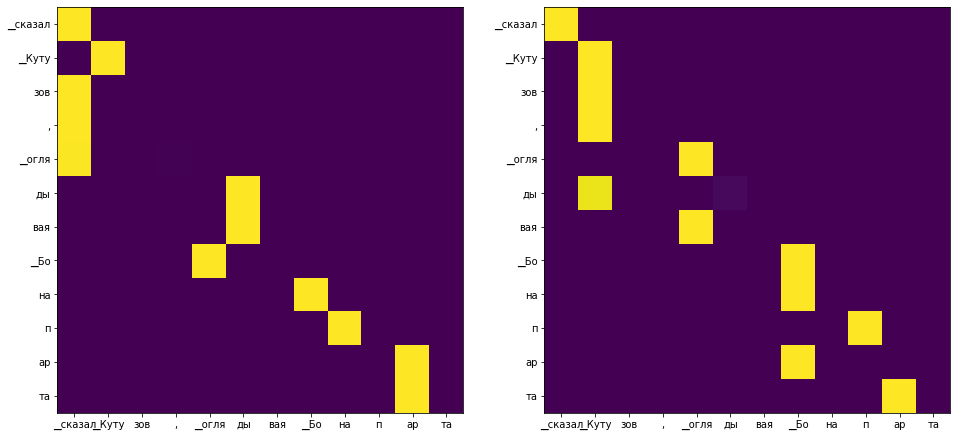

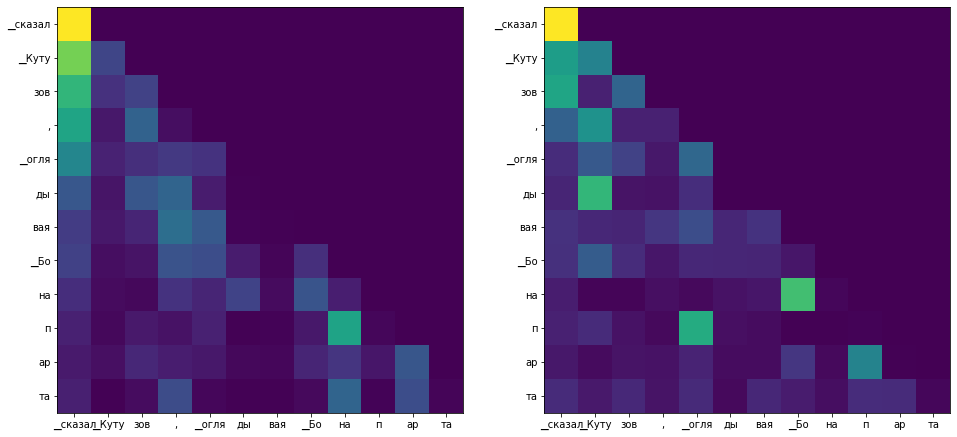

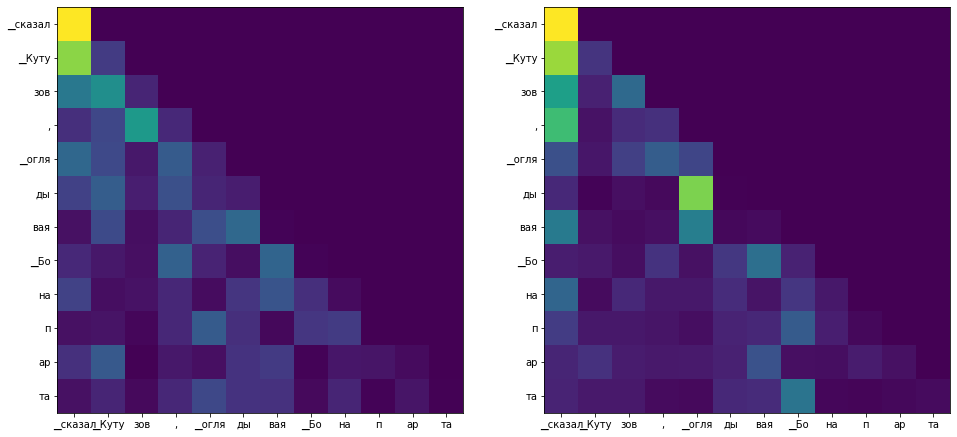

In [38]:
plot_attention_maps(my_transf_model, 'сказал Кутузов, оглядывая Бонапарта', tokenizer)

 Здесь мы видим несколько графиков, каждая вот такая вот строка (слова вдоль оси Y) соответствует слою трансформера (то есть это самый первый слой трансформера, дальше идёт второй слой трансформера...), а каждый столбец соответствует голове (то есть, это — первые головы, это — вторые головы для каждого слоя). Можно больше, у нас в модели всего 16 голов, но, просто — не влезло бы. По строкам здесь отложены запросы, и каждая позиция помечена токеном во входной последовательности, который стоял на этой позиции. По столбцам отложены ключи. Здесь у нас запросы (queries, ось Y), а здесь у нас ключи (keys ось X). И, чем ярче клеточка на пересечении строки и столбца, тем более значим этот ключ для этого запроса (по мнению модели). Мы видим, что на первом слое карты активации очень контрастные, очень разреженные. То есть, для каждой выходной позиции близок только один ключ. Интересно обратить внимание вот на эти строки. Эти стройки соответствуют токенам, то есть N-граммам из имени Бонапарта. Интересно, что для почти всех N-грамм из имени, наиболее значимым ключом является первая N-грамма этого имени (то есть у нас есть такие связи). То есть для вычисления признаков (вот, например, для этой позиции) очень важны признаки начала имени. Это и есть учёт контекста. У второй головы карта активации совершенно другая. Здесь, кажется, в вычислении признаков для всех токенов после запятой самый важный исходный токен — это сама "запятая", то есть мы, как бы, отделяем деепричастный оборот здесь. Конечно, это всего лишь — мои попытки натянуть какую-то рационализацию на эти карты активации, неочевидно, что вообще эти карты активации для человека будут понятны или полезны. Но иногда на них просто интересно посмотреть. На втором слое трансформера карты активации уже более сглаженные, уже нету каких-то отдельных, выделенных, наиболее значимых позиций, уже каждая позиция обращает внимание, в принципе, на все предыдущие позиции. Обратите внимание, что верхняя половина этих карт — тёмная. Это именно то, чего мы хотели добиться, применяя маску зависимостей. То есть здесь в маске зависимости на этих позициях стоит -infinity.

Ну, что ж, это был большой семинар, который был посвящён сразу нескольким темам — а именно, моделированию языка, byte pair encoding (то есть какая-то токенизация универсальная, современная, которая позволяет выбирать между длиной последовательностей и размером словаря). Мы попробовали применить такую токенизацию путём использования библиотеки "YouTokenToMe". Затем мы собрали и обучили языковую модель, используя реализацию трансформера из стандартной библиотеки pytorch, мы попробовали погенерировать тексты с помощью "полностью жадного" алгоритма и с помощью "лучевого поиска". А затем мы рассмотрели — а как же можно руками, самостоятельно, не используя готовой библиотеки, реализовать механизм внимания — используя только базовые операции из pytorch. И, таким образом, мы собрали свой энкодер для трансформера, реализовав механизм внимания с несколькими головами, реализовав "self attention", реализовав отдельный слой трансформера и собрав это всё в encoder. А также мы обучили нашу реализацию и увидели, что она, в принципе, работает примерно так же, как и стандартная реализация — значит, что, кажется, мы не ошиблись. А ещё, напоследок, мы заглянули внутрь обученной модели и посмотрели, как между собой связываются входные и выходные позиции на разных уровнях и для разных голов. Спасибо за внимание!

![img](img/4.6.1.png)